In [ ]:
import numpy as np
from numpy import save
from numpy import asarray
from numpy import random
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pygame
import os
import collections
from tensorflow import keras 
from keras.utils import load_img
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import confusion_matrix
import scipy
import seaborn as sns
from scipy.ndimage import rotate
from keras.src.legacy.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Helper methods

In [ ]:
import re

def extract_number(text):
    match = re.search(r'\d+', text)
    if match:
        number = int(match.group())
        return number
    else:
        raise ValueError("No number found in the text")

In [55]:
# Helper method for ploting accuracy, loss plots
def plot_loss_accuracy(history, include_val_plot):
    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label = "Train Loss")
    if include_val_plot:
      ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('Cross entropy loss')
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label = "Train Accuracy")
    if include_val_plot:
      ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('Accuracy')
    ax.grid(True)

# Pre process

In [39]:
data_folder = './data'
alloed_image_formats = ('.jpeg', '.jpg', '.png')
images, labels = [], []

for subfolder in os.listdir(data_folder):
    subfolder_path = os.path.join(data_folder, subfolder) # data/{01 or 02 or 03}
    
    if os.path.isdir(subfolder_path):
        label = extract_number(subfolder)
        
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)
            
            try:
                if file_path.lower().endswith(alloed_image_formats):
                    image = load_img(file_path, target_size=(256, 256))
                    image_as_array = asarray(image)
                    
                    images.append(image_as_array)
                    labels.append(label)
            except:
                print('Can\'t load', file_path)
                continue

print('Number of images: ', len(images))
print('Number of labels: ', len(labels))

Number of images:  251
Number of labels:  251


And the label for the image is: 1


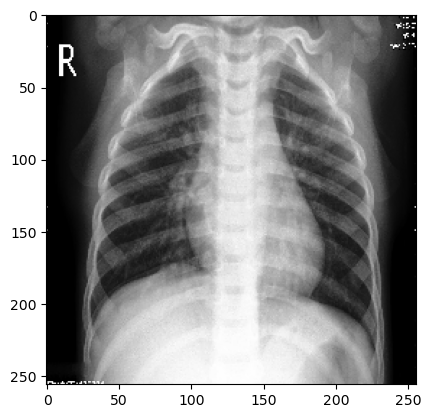

In [40]:
plt.imshow(images[20])
print('And the label for the image is:' , labels[20])

And the label for the image is: 2


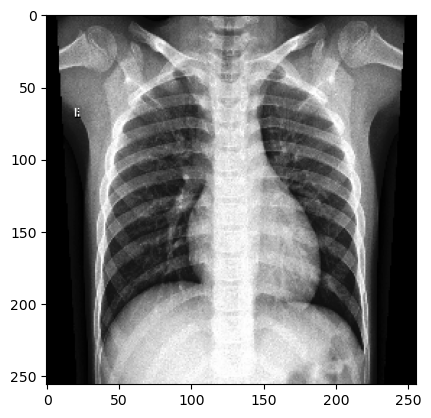

In [41]:
plt.imshow(images[100])
print('And the label for the image is:' , labels[100])

In [42]:
counter = collections.Counter(labels)
list_of_keys = list(map(lambda e: ([e]), list(counter.keys())))
list_of_values = list(counter.values())

print('The distribution of classes inside the data:')
for i in range(len(list_of_keys)):
  print(list_of_keys[i] , ' : ', list_of_values[i])

The distribution of classes inside the data:
[1]  :  70
[2]  :  70
[3]  :  111


In [44]:
# Convert lists to arrays
images = asarray(images)
labels = asarray(labels)

In [46]:
# We don't get any benefit from the image colors, that's why we decided to scale the image pixels.
# We made them to be in [0, 1] range by deviding in 255.
scaled_photos = images.astype("float32") / 255
print(scaled_photos[100][0])

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.0627451  0.0627451  0.0627451 ]
 [0.06666667 0.06666667 0.06666667]
 [0.06666667 0.06666667 0.06666667]
 [0.07058824 0.07058824 0.07058824]
 [0.07450981 0.07450981 0.07450981]
 [0.09019608 0.09019608 0.09019608]
 [0.09019608 0.09019608 0.09019608]
 [0.09803922 0.09803922 0.09803922]
 [0.10588235 0.10588235 0.10588235]
 [0.14117648 0.14117648 0.14117648]
 [0.15686275 0.15686275 0.15686275]
 [0.14509805 0.14509805 0.14509805]
 [0.17254902 0.17254902 0.17254902]
 [0.19215687 0.19215687 0.19215687]
 [0.19607843 0.19607843 0.19607843]
 [0.21176471 0.21176471 0.21176471]
 [0.21568628 0.21568628 0.21568628]
 [0.21176471 0.21176471 0.21176471]
 [0.23921569 0.23921569 0.23921569]
 [0.20392157 0.20392157 0.20392157]
 [0.20784314 0.20784314 0.20

# Data prepreation

In order to evaluate the model we will use a split of train and test parts from the data. The train will use for learning and the test will use for calculations of metrics.

In addition, in order to build a successful model, we will use another part, validation set. During the learning and the training of the model, we will use the validation set to make it more accurate and improvment.
We will use the train_test_split method of sklearn library.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42) # 0.25 x 0.8 = 0.2
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'val samples')
print(X_test.shape[0], 'test samples')

150 train samples
50 val samples
51 test samples


In [48]:
NUM_CLASSES = 3

In [54]:
y_train_encoded = to_categorical(y_train -1, NUM_CLASSES)
y_val_encoded = to_categorical(y_val -1, NUM_CLASSES)
y_test_encoded = to_categorical(y_test -1, NUM_CLASSES)
print(y_train_encoded[100], 'in shape: ', y_train_encoded.shape)

[0. 0. 1.] in shape:  (150, 3)


# Model selection and construction

In [59]:
model = keras.Sequential(
    [
        keras.Input(shape = (256,256,3)),
        tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = "relu"),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size = (3, 3), activation = "relu"),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(NUM_CLASSES, activation = "softmax"),
    ]
)

In [60]:
model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"])

In [61]:
history = model.fit(X_train, y_train_encoded,
                    batch_size = 256,
                    epochs = 25,
                    shuffle = True)

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4133 - loss: 23.5994
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2533 - loss: 9858.9160
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2533 - loss: 4189.3848
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2533 - loss: 272.4891
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5133 - loss: 296.1544
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2533 - loss: 953.6240
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2533 - loss: 334.9240
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4933 - loss: 193.3483
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7200 - loss: 11.2610
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7800 - loss: 11.0251
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9333 - loss: 1.3165
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9733 - loss: 0.6686
Epoch 

In [62]:
score = model.evaluate(X_test, y_test_encoded)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7283 - loss: 21.7303
Test loss: 25.261459350585938
Test accuracy: 0.686274528503418


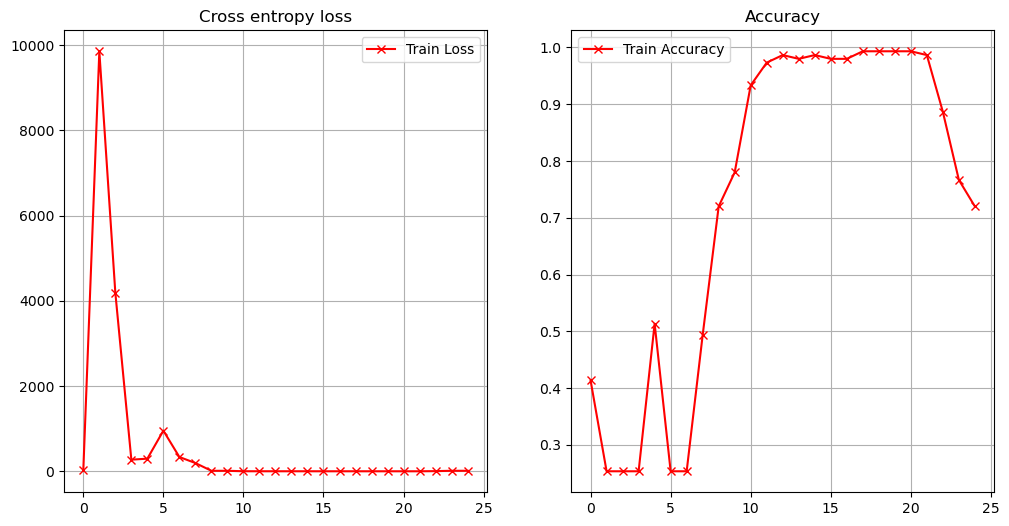

In [63]:
plot_loss_accuracy(history, False)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │       738,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 757,443 (2.89 MB)

 Trainable params: 757,443 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3000 - loss: 39.5483 - val_accuracy: 0.3600 - val_loss: 7735.6890
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4933 - loss: 6015.9976 - val_accuracy: 0.3000 - val_loss: 2100.5554
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2533 - loss: 2219.6094 - val_accuracy: 0.4200 - val_loss: 138.3056
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5733 - loss: 98.5318 - val_accuracy: 0.3400 - val_loss: 58.9406
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3200 - loss: 55.6429 - val_accuracy: 0.6600 - val_loss: 97.6150
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7200 - loss: 72.7605 - val_accuracy: 0.5000 - val_loss: 97.4304
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6333 - loss: 61.8601 - val_accuracy: 0.5600 - val_loss: 38.6614
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4867 - loss: 39.9629 - val_accuracy: 0.6000 - val_

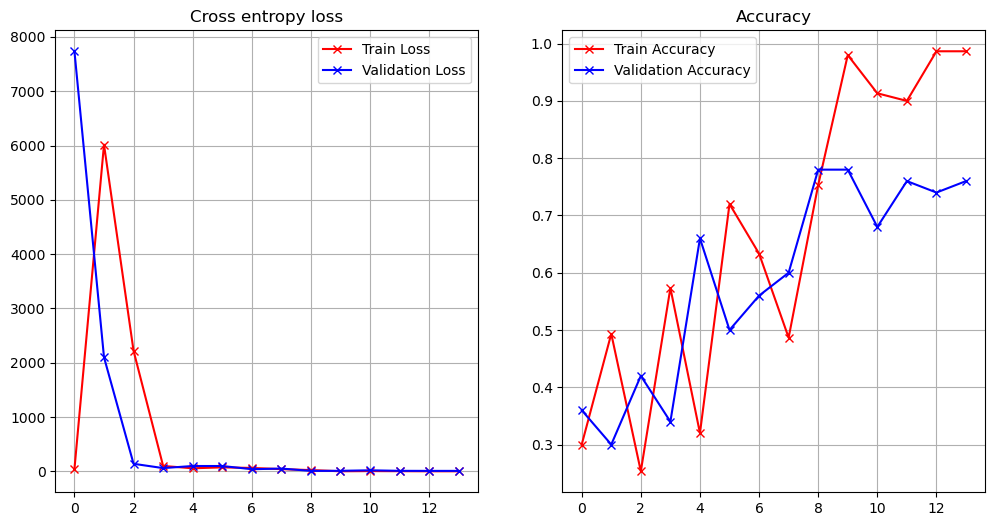

In [65]:
model_2 = keras.Sequential(
    [
        keras.Input(shape = (256, 256, 3)),
        tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = "relu", kernel_regularizer = l2(0.01)),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size = (3, 3), activation = "relu", kernel_regularizer = l2(0.01)),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CLASSES, activation = "softmax"),
    ]
)

print(model_2.summary())

model_2.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'])

epochs = 25
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True)
history_2 = model_2.fit(X_train, y_train_encoded,
                        batch_size = 256, epochs= epochs,
                        validation_data = (X_val, y_val_encoded),
                        callbacks = [early_stopping],
                       )

score_2 = model_2.evaluate(X_test, y_test_encoded)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

plot_loss_accuracy(history_2, True)